# STIRAP
### TODO:
 * add Louvillian op
 * add in realistic experimental parameters, i.e. insufficient blue Rabi frequency
 * for larger more gross hamiltonians (e.g. multi-atom rydberg blockade
 stuff), consider using either of the following:
   * generalized methods from stirap_symbolic.ipynb; may want to code in the RWA though... 
   * writing a function to spit out the rhs of the von neumann eqs using the general result for diagonal/off-diagonal terms for a given hamiltonian
 
### Conditions for STIRAP
 1. The mixing angle θ(t) of Eq. (12) varies slowly (adiabatically). 
 2. The P pulse is negligible at the start of the pulse sequence (|θ| → 0 mod π). 
 3. The S pulse is negligible at the termination of the pulse sequence (jθj → π∕2 mod π). 
 4. The two-photon detuning remains zero, i.e., δ = 0. 
 5. The single-photon detuning Δ is constant (optimally zero). 

In [1]:
%matplotlib inline

In [2]:
from numpy import *
# import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import sympy
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
import time

from physconsts import *
from rbconsts import *
from amophys import cc

from atomsim import AtomSim

## Test the AtomSim class

In [3]:
def derivs(y0,t,O1,O2,D1,D2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    r11,r12,r13,r22,r23,r33 = y0
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

In [6]:
rho0 = zeros(6, complex)
rho0[0] = 1 + 0j # population starts in ground state

w = 10
dt = 20
t_exp = 120
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

sim = AtomSim(rho0, func, t_exp, tcentered=True)

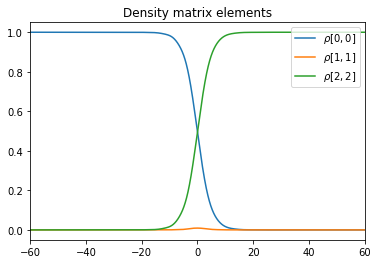

In [7]:
rho, t = sim.runsim()
fig, axes = sim.plots(show=['populations'])

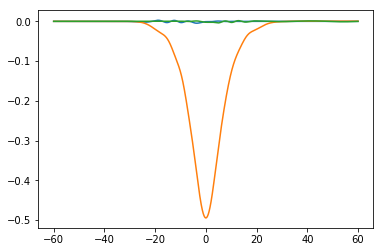

In [8]:
for c in sim.coherences:
    plt.plot(t, c)

## 3-lvl STIRAP - not class-based
this works. base the above class off of this code. 

In [16]:
#### functions 

def derivs(y0,t,O1,O2,D1,D2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    r11,r12,r13,r22,r23,r33 = y0
#     O1,2; D1,2= params # Rabi freq, detuning
    
    # time derivatives of density op elements; non-redundant eqs only
    dr11 = .5*1j*O1*(cc(r12) - r12)
    dr12 = -.5*1j*(O1*r11 + 2*D1*r12 + O2*r13 - O1*r22)
    dr13 = -.5*1j*(O2*r12 + 2*(D1 + D2)*r13 - O1*r23)
    dr22 = .5*1j*(-O1*cc(r12) + O2*cc(r23) + O1*r12 - O2*r23)
    dr23 = .5*1j*(O1*r13 - O2*r22 - 2*D2*r23 + O2*r33)
    dr33 = .5*1j*O2*(r23 - cc(r23))
    
    return array([dr11,dr12,dr13,dr22,dr23,dr33])

def runsim(func, idx=0, t_exp=60, tcentered=False):
    """ func is the derivs function
        idx is the index of the unraveled density matrix where 
            the population starts
        t_exp is experiment duration. t_2pi = 2*pi/w_rabi for 
            the simple three-level system
    """
    dt = 0.01 # timestep for DE solver
    t = arange(t_exp,step=dt)
    if tcentered == True:
        t -= t_exp/2
    tspan = [t[0],t[-1]]

    y0 = zeros(6, complex)
    y0[0] = 1 + 0j # all population in ground state rho11

    return solve_ivp(func,tspan,y0,t_eval=t)#linspace(0,t_exp,400))

# # the dressed states
# psi_1 = lambda

In [75]:
dt = 0.01 # timestep for DE solver
t_exp = 60
t = arange(t_exp,step=dt)
t -= t_exp/2
len(t)

6000

In [85]:
#### parameters for coherent |g> <--> |r> oscillation 
# w = 1 # doesn't matter here
# t2 = 1 # doesn't matter here
# t1 = t2 + 5 # doesn't matter here
# O2 = lambda t: 2*pi*1 #exp(-((t-t2)/w)**2/2) # arb units
# O1 = lambda t: 2*pi*1 #exp(-((t-t1)/w)**2/2)
# D1 = 2*pi*10 # arb units
# D2 = lambda t: -D1# + (O1(t)**2 - O2(t)**2)/4*D1

#### parameters for stirap maybe
w = 10
dt = 20
Omax = 2*pi*.4 # this width and amplitude give A = 2*pi
O2 = lambda t: Omax*exp(-((t+dt/2)/w)**2/2)
O1 = lambda t: Omax*exp(-((t-dt/2)/w)**2/2)
D1 = 0.1*Omax # (finite to prevent 1/0 error in D2)
D2 = lambda t: -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

In [86]:
# func = lambda y,t: derivs(t,y,O1(t),O2(t),D1,D2(t))
func = lambda t,y: derivs(y,t,O1(t),O2(t),D1,D2(t))

soln = runsim(func, t_exp=120, tcentered=True)

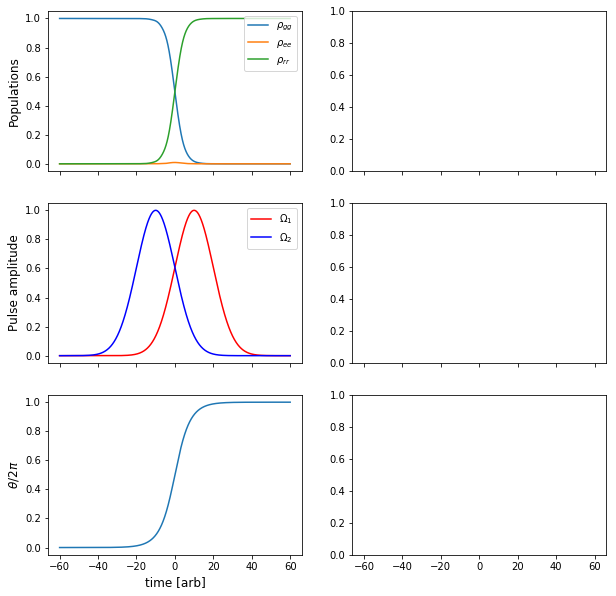

In [87]:
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex=True)
fntsize = 12
unit = 1 #2*pi # divide

# populations -- interaction basis {|g>,|e>,|r>}
# ax[0][0].set_title('Population evolution w/o spontaneous emission')
ax[0][0].set_ylabel('Populations', size=fntsize)
for i,l in zip([0,3,5],[r'$\rho_{gg}$',r'$\rho_{ee}$',r'$\rho_{rr}$']):
    ax[0][0].plot(soln.t/unit,soln.y[i],label=l)
ax[0][0].legend(loc='upper right')

# rabi frequency
ax[1][0].set_ylabel('Pulse amplitude', size=fntsize)
ax[1][0].plot(soln.t,O1(soln.t)/Omax,c='r',label=r'$\Omega_1$')
ax[1][0].plot(soln.t,O2(soln.t)/Omax,c='b',label=r'$\Omega_2$')
ax[1][0].legend(loc='upper right')

# mixing angle
ax[2][0].set_ylabel(r'$\theta / 2\pi$', size=fntsize)
ax[2][0].plot(soln.t, arctan(O1(soln.t)/O2(soln.t))/(pi/2))
ax[2][0].set_xlabel('time [arb]', size=fntsize)

# populations in dressed basis {|B+>,|D>,|B->}
# coherences
# for i,l in zip([1,2],[r'$\rho_{ge}$', r'$\rho_{gr}$']): ## this isn't correct
#     ax[0][1].plot(soln.t,soln.y[i], label=l)
# ax[0][1].set_ylim((0,1))
# ax[0][1].legend(loc='upper right')

# plot population in ee vs single pulse area? 

plt.show()